# Detektor Teks Buatan AI untuk Esai Bahasa Inggris Menggunakan XLM-RoBERTa

## Import Libraries

In [ ]:
# after running this code, then restart session
!pip install evaluate -q
!pip install accelerate -q
!pip install wandb -q

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plotter
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# SET GPU
try:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    # Set memory growth to avoid pre-allocating all the GPU memory
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
    # Set up the distribution strategy for the first GPU
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
except RuntimeError as e:
    print(e)
    # Fallback to the default strategy if an error occurs
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Wed Jul  3 07:43:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              25W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
os.environ["WANDB_API_KEY"] = "0"

In [ ]:
!gdown 1SQzZX_ghL7nMdr3smrILsNb-4gghzds4

Downloading...
From: https://drive.google.com/uc?id=1SQzZX_ghL7nMdr3smrILsNb-4gghzds4
To: /content/Training_Essay_Data.csv
100% 65.5M/65.5M [00:01<00:00, 42.7MB/s]


## Read Dataset

In [ ]:
train = pd.read_csv("Training_Essay_Data.csv", names=['text', 'label'], header=0)
train

,text,label
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1
...,...,...
29140,There has been a fuss about the Elector Colleg...,0
29141,Limiting car usage has many advantages. Such a...,0
29142,There's a new trend that has been developing f...,0
29143,As we all know cars are a big part of our soci...,0


In [ ]:
# split the dataset into training and testing sets with 80% training data and 20% testing data
train, test = train_test_split(train, test_size=0.2, random_state=42)

# reset the index to ensure indices start from 0
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
# display the first few rows and info of the dataframe
def display_data_info(df, name):
    print(f"--- {name} DataFrame ---")
    print("Head:")
    display(df.head())
    print("\nInfo:")
    display(df.info())
    print("\n")

# display train dataframe
display_data_info(train, "Train")

# display test dataframe
display_data_info(test, "Test")

--- Train DataFrame ---
Head:


,text,label
0,If I were a scientist at NASA I will not belie...,0
1,"""America's love affair with it's vehicles seem...",0
2,There is a great challenge when it comes to ex...,0
3,Cell phones have become very popular over the ...,0
4,From the research and development of Dr. Huang...,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23316 entries, 0 to 23315
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23316 non-null  object
 1   label   23316 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 364.4+ KB


None



--- Test DataFrame ---
Head:


,text,label
0,I would agree with Emerson's in this world be ...,0
1,Advice is wonderful and helpful to everyone. S...,0
2,I think that limiting car usage is great for t...,0
3,Nobody know how the face got on mars because w...,0
4,The student has studied lot of subjects in the...,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5829 entries, 0 to 5828
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5829 non-null   object
 1   label   5829 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.2+ KB


None

## Visualization

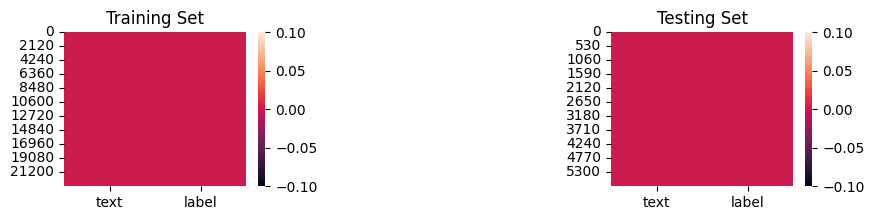

In [ ]:
plt.figure(figsize = (10, 2))

plt.subplot(1, 3, 1)
plt.title("Training Set")
sns.heatmap(train.isnull())

plt.subplot(1, 3, 3)
plt.title("Testing Set")
sns.heatmap(test.isnull())
plt.show()

In [ ]:
labels, frequencies = np.unique(train.label.values, return_counts = True)

fig = px.pie(values=frequencies,
             names=labels,
             title='train :label distribution',
             color_discrete_sequence=px.colors.sequential.Plotly3)

fig.show()

In [ ]:
labels, frequencies = np.unique(test.label.values, return_counts = True)

fig = px.pie(values=frequencies,
             names=labels,
             title='test :label distribution',
             color_discrete_sequence=px.colors.sequential.Plotly3)

fig.show()

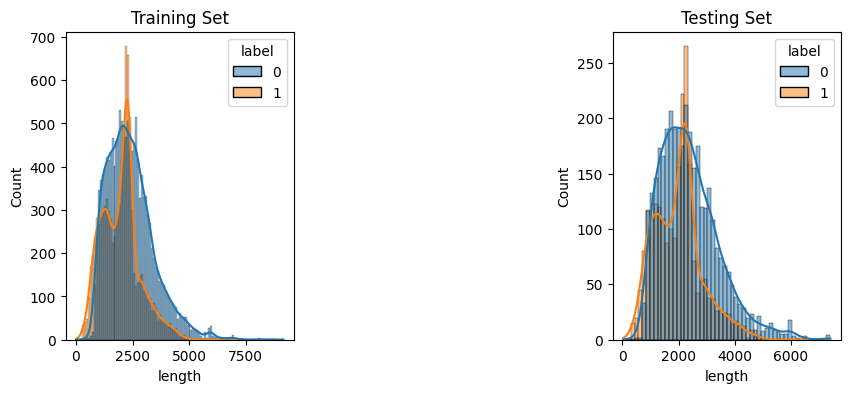

In [ ]:
train['length'] = train['text'].apply(len)
test['length'] = test['text'].apply(len)

plt.figure(figsize = (10, 4))

plt.subplot(1, 3, 1)
plt.title("Training Set")
sns.histplot(train,x='length',hue='label',kde=True)

plt.subplot(1, 3, 3)
plt.title("Testing Set")
sns.histplot(test,x='length',hue='label',kde=True)
plt.show()

In [ ]:
label_count = train['label'].value_counts().sort_index()
label_count

label
0    13969
1     9347
Name: count, dtype: int64

In [ ]:
label_names = ['Human', 'AI'] #SET 0/1 →ham/spam
label_count.index = label_names
display(label_count)

fig = go.Figure([go.Bar(x=label_names, y=label_count, marker_color='skyblue')])

fig.update_layout(title_text='Number of entries per label', # title of plot
                  xaxis_title_text='Label', # xaxis label
                  yaxis_title_text='Count', # yaxis label
                  )
fig.show()

Human    13969
AI        9347
Name: count, dtype: int64

## Modeling

### 1. Tokenizer

In [ ]:
import evaluate
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

In [ ]:
# specify the model name for the tokenizer
model_name = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
train.columns

Index(['text', 'label', 'length'], dtype='object')

In [ ]:
test.columns

Index(['text', 'label', 'length'], dtype='object')

In [ ]:
# delete unnecessary columns
train = train.drop(labels=['length'], axis=1)
test = test.drop(labels=['length'], axis=1)

### 2. DatasetDict

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
# split the training data into training and validation sets with 80% training data and 20% validation data
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# convert the dataframe to HF dataset
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test)

# create a DatasetDict to hold the training, validation, and test dataset
ds = DatasetDict()
ds['train'] = train_ds
ds['validation'] = val_ds
ds['test'] = test_ds

In [ ]:
# function to tokenize the 'text' column of the data
def tokenizer_sentence(data):
    return tokenizer(data['text'], truncation=True)  #feature columns

### 3. Map

In [ ]:
# apply the tokenizer_sentence function to each split in the dataset (train, validation, test)
tokenized_ds = ds.map(tokenizer_sentence, batched=True)

Map:   0%|          | 0/18652 [00:00<?, ? examples/s]

Map:   0%|          | 0/4664 [00:00<?, ? examples/s]

Map:   0%|          | 0/5829 [00:00<?, ? examples/s]

In [ ]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 18652
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4664
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5829
    })
})

### 4. DataCollatorWithPadding

In [ ]:
# create a data collator that will dynamically pad the inputs to the maximum length of a batch
# this ensures that all inputs in a batch are of the same length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 5. Build Model

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaModel

In [ ]:
class CustomXLMRobertaModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomXLMRobertaModel, self).__init__()
        model_name = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'
        self.roberta = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_labels)
        )
        self.loss = nn.CrossEntropyLoss()
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.classifier(output)

        if labels is not None:
            loss = self.loss(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}
        else:
            return logits

In [ ]:
model = CustomXLMRobertaModel(num_labels=2)

config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at symanto/xlm-roberta-base-snli-mnli-anli-xnli and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 6. TrainingArguments

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_metric

In [ ]:
# set up the training arguments for the model
training_args = TrainingArguments("/content",
                                  optim="adamw_torch",
                                  num_train_epochs=1,
                                  evaluation_strategy="epoch",
                                  logging_dir='./logs',
                                  logging_steps=10,
                                  report_to="none",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  fp16=True)

# load the f1 metric for evaluation
f1_metric = load_metric("f1", trust_remote_code=True)

# function to compute evaluation metrics
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_metric.compute(predictions=predictions, references=labels, average="micro")
    }

In [ ]:
from transformers import Trainer

# initialize the trainer with the specified arguments and datasets
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

### 7. Setup Environment

In [ ]:
import os

# disable weights & biases (wandb) logging by setting the environment variable
os.environ["WANDB_DISABLED"] = "false"

## Training

In [ ]:
# start training process
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.001000,0.042335,0.989708,{'f1': 0.9897084048027445}


TrainOutput(global_step=1166, training_loss=0.08195076241296928, metrics={'train_runtime': 899.5958, 'train_samples_per_second': 20.734, 'train_steps_per_second': 1.296, 'total_flos': 0.0, 'train_loss': 0.08195076241296928, 'epoch': 1.0})

## Predictions

In [ ]:
# generate predictions on test dataset
predictions = trainer.predict(tokenized_ds["test"])
predictions

PredictionOutput(predictions=array([[ 4.2539062, -4.1289062],
       [ 3.4765625, -2.9882812],
       [ 4.2617188, -4.1210938],
       ...,
       [-4.4609375,  4.3164062],
       [ 4.2617188, -4.0820312],
       [ 4.2617188, -4.1171875]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 0, 0]), metrics={'test_loss': 0.057315643876791, 'test_accuracy': 0.987304855035169, 'test_f1': {'f1': 0.987304855035169}, 'test_runtime': 70.1861, 'test_samples_per_second': 83.051, 'test_steps_per_second': 5.2})

In [ ]:
# convert the predictions from numpy array to pytorch tensor
logits = torch.from_numpy(predictions.predictions)
logits

tensor([[ 4.2539, -4.1289],
        [ 3.4766, -2.9883],
        [ 4.2617, -4.1211],
        ...,
        [-4.4609,  4.3164],
        [ 4.2617, -4.0820],
        [ 4.2617, -4.1172]])

In [ ]:
# create dataframe from the logits
test_pred_df = pd.DataFrame(logits)
test_pred_df

,0,1
0,4.253906,-4.128906
1,3.476562,-2.988281
2,4.261719,-4.121094
3,4.261719,-4.117188
4,-4.226562,4.179688
...,...,...
5824,3.824219,-3.353516
5825,-4.359375,4.292969
5826,-4.460938,4.316406
5827,4.261719,-4.082031


In [ ]:
# extract first column
test_pred_df = test_pred_df[0]
test_pred_df = pd.DataFrame(test_pred_df)
test_pred_df

,0
0,4.253906
1,3.476562
2,4.261719
3,4.261719
4,-4.226562
...,...
5824,3.824219
5825,-4.359375
5826,-4.460938
5827,4.261719


In [ ]:
# adjust predictions: set values <= 0 to 0 and values > 0 to 1, then reverse the labels
test_pred_df[0][test_pred_df[0] <= 0] = 0
test_pred_df[0][test_pred_df[0] > 0] = 1
test_pred_df[0] = test_pred_df[0].replace({0:1,1:0}) # reverse

In [ ]:
# rename the column
test_pred_df = test_pred_df.set_axis(axis=1,labels=['pred'])
test_pred_df

,pred
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
5824,0.0
5825,1.0
5826,1.0
5827,0.0


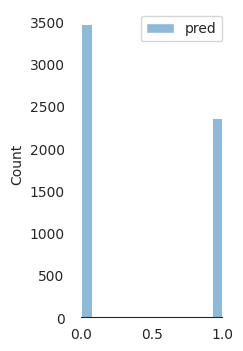

In [ ]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(2, 4))
sns.histplot(test_pred_df)
ax.xaxis.grid(False)
sns.despine(trim=True, left=True)
plt.show()

In [ ]:
# merge the test dataframe with test_pred_df
test_pred_all = test.merge(test_pred_df, how='inner', left_index=True, right_index=True)
test_pred_all

,text,label,pred
0,I would agree with Emerson's in this world be ...,0,0.0
1,Advice is wonderful and helpful to everyone. S...,0,0.0
2,I think that limiting car usage is great for t...,0,0.0
3,Nobody know how the face got on mars because w...,0,0.0
4,The student has studied lot of subjects in the...,1,1.0
...,...,...,...
5824,The face that you see on mars was not somethin...,0,0.0
5825,"Recently, the modern technology develops very ...",1,1.0
5826,"Nowadays, people make their advertisements so ...",1,1.0
5827,The advantages of limiting car usage is that l...,0,0.0


## Accuracy Score

accuracy is: 98.748%


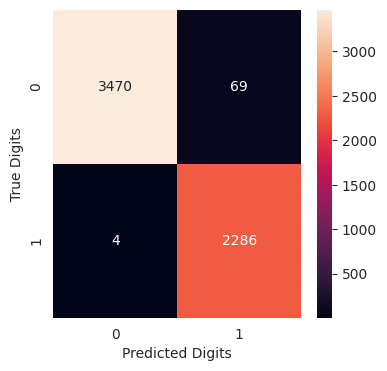

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

acc = accuracy_score(test_pred_all['label'], test_pred_all['pred'])
print("accuracy is: {0:.3f}%".format(acc * 100))

cm = confusion_matrix(test_pred_all['label'] , test_pred_all['pred'])
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted Digits")
plt.ylabel("True Digits")
plt.show()